In [2]:
import sys
sys.path.append('../src')
import pandas as pd
import cv2
import supervision as sv
import numpy as np
import os
import pickle as pl
import torch
import segmentation_models_pytorch as smp
from os.path import expanduser
from custom_datasets import *
from unet_model import *
from models import *

In [3]:
home = expanduser("~")
main_path = home+"/Active-Learning-Segmentation/"
dataframes_path = main_path + "data/dataframes/"
trained_models = main_path + "scripts/notebooks/trained_models/"
notebooks_path = main_path + "scripts/notebooks/"

In [4]:
df_name = "lung_df"
train_df = pd.read_csv(dataframes_path+"lung_df_train.csv")
test_df = pd.read_csv(dataframes_path+"lung_df_test.csv")

In [5]:
params = {'n_epoch': 35,
          'train_args':{'batch_size': 4, 'num_workers': 1},
          'test_args':{'batch_size': 256, 'num_workers': 1},
          'optimizer_args':{'lr': 5e-3, 'momentum': 0.9},
          'use_sam': True,
          'use_predictor': True,
          'use_generator': False,
          'init_set_size': 100,
          'rounds': 2,
          "activate_sam_at_round":1, 
          "img_size":(128, 128),
          "voting" : True,
          "pre_trained": False,
          "dataset": "Lung_Tumor_Dataset",
          "similarity_check": True}

if params["init_set_size"] == len(train_df):
    params["training_type"] = "no_active"
elif not params["use_sam"]:
    params["training_type"] = "no_sam"
elif params["voting"]:
    params["training_type"] = "voters"
else:
    params["training_type"]="withSAM_NoVoting"

if params["training_type"] == "no_active":
    if params["pre_trained"]:
        params["model_path"] = f'{notebooks_path}trained_models/{params["dataset"]}/no_active/pre_trained_Unet_{params["img_size"][0]}.pt'
    else:
        params["model_path"] = f'{notebooks_path}trained_models/{params["dataset"]}/no_active/not_pre_trained_Unet_{params["img_size"][0]}.pt'
else:
    params["model_path"] = f'{notebooks_path}trained_models/{params["dataset"]}/{params["training_type"]}/{params["init_set_size"]}'
    
params['test_set_size'] = len(test_df)
params['df'] = df_name
params['query_num'] = int(0.05 * params['init_set_size'])
if params['query_num'] == 0:
    params['query_num'] = 1
params["strategy"] = "MarginSampling"

if params["training_type"] == "voters":
    if params["similarity_check"]:
        params["model_path"] = f'{params["model_path"]}_dbscan'
    params["model_path"] = f'{params["model_path"]}/voters_{params["img_size"][0]}'
        

In [6]:
voters_dbscan = [trained_models + f'{params["dataset"]}/voters/{params["init_set_size"]}_dbscan/voters_{params["img_size"][0]}_{params["rounds"]-1}/model_{i}.pt' for i in range(1,10)]
main_dbscan = trained_models + f'{params["dataset"]}/voters/{params["init_set_size"]}_dbscan/voters_{params["img_size"][0]}_{params["rounds"]-1}/main_Unet.pt'
voters_dbscan.append(main_dbscan)

In [7]:
params["model_path"]

'/home/jovyan/Active-Learning-Segmentation/scripts/notebooks/trained_models/Lung_Tumor_Dataset/voters/100_dbscan/voters_128'

In [8]:
images = []
gt_masks = []
for i in range(50):
    images.append(np.load(test_df["images"][i], allow_pickle=True))
    gt_masks.append(np.load(test_df["masks"][i], allow_pickle=True))

In [9]:
len(images)

50

In [10]:
test_df_slice = test_df[:50]
def get_data(handler, train_df, test_df):
    return Data(train_df["images"].to_list(), train_df["masks"].to_list(), test_df["images"].to_list(), test_df["masks"].to_list(), handler, img_size=params["img_size"], df=train_df, path= main_path+"/data/processed/", use_sam=params['use_sam'])

data = get_data(Handler, train_df, test_df_slice)
data.initialize_labels(params["init_set_size"])

In [11]:
trained_models_dir = notebooks_path+"trained_models"    
if params["pre_trained"]:
    model = smp.create_model('Unet', encoder_name='resnet34', in_channels=3, classes = 1)
    first_rd_Unet = torch.load(notebooks_path+f"trained_models/shared_1st_state_pre_trained_{params['init_set_size']}.pt")
else:
    model = UNet(n_channels=3, n_classes=1, bilinear=True)
    first_rd_Unet = torch.load(notebooks_path+f"trained_models/shared_1st_state_not_trained_{params['init_set_size']}.pt")
    
model.load_state_dict(first_rd_Unet)

<All keys matched successfully>

In [12]:
net = Net(model, params, device = torch.device("cuda"))

In [13]:
def predict(net, model_state:str):
    net.net.load_state_dict(torch.load(model_state))
    net.clf = net.net.to(torch.device("cuda"))
    logits = net.predict(data.get_test_data())[0]
    logits = logits.squeeze().cpu()
    mask = (logits.sigmoid()> 0.5).float()
    
    return mask, logits

In [14]:
tmp_dbscan = [predict(net, path) for path in voters_dbscan]

In [15]:
len(tmp_dbscan[0][0])

50

In [16]:
voters_dbscan_masks = []
voters_dbscan_logits = []
for j in range(len(tmp_dbscan[0][0])):
    voters_dbscan_masks.append([tmp_dbscan[i][0][j] for i in range(len(tmp_dbscan))])
    voters_dbscan_logits.append([tmp_dbscan[i][1][j] for i in range(len(tmp_dbscan))])

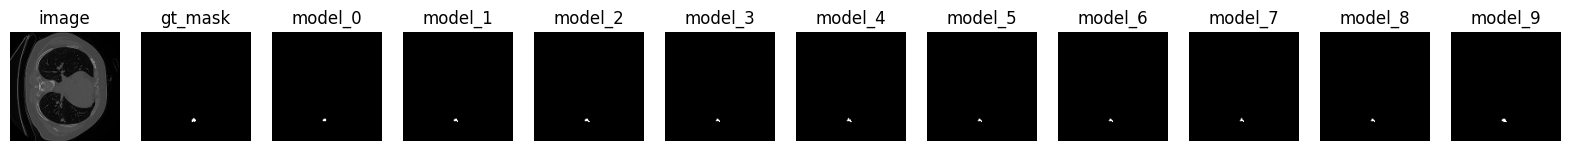

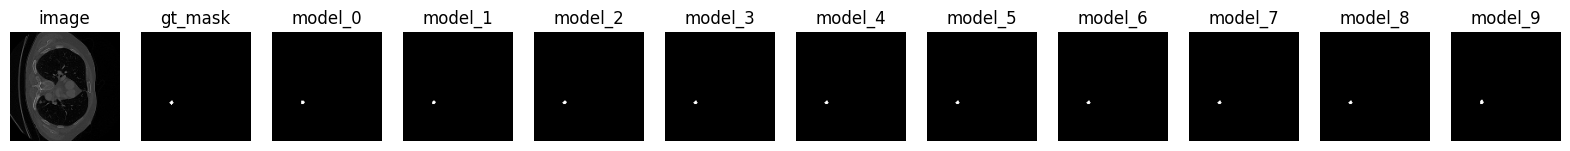

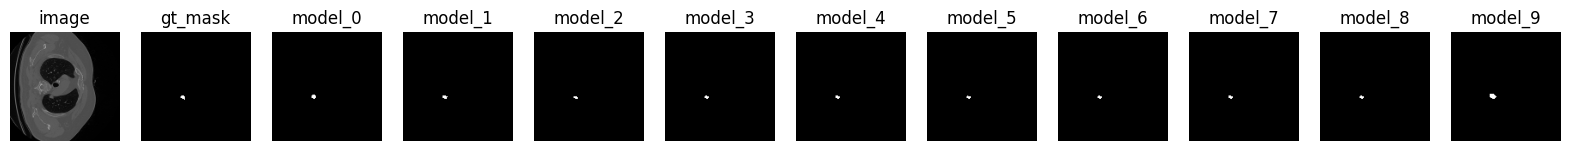

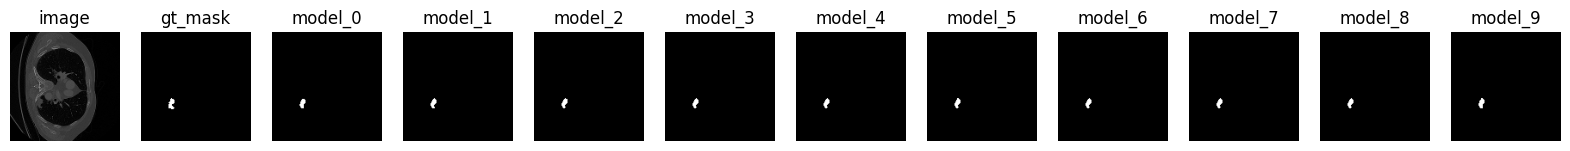

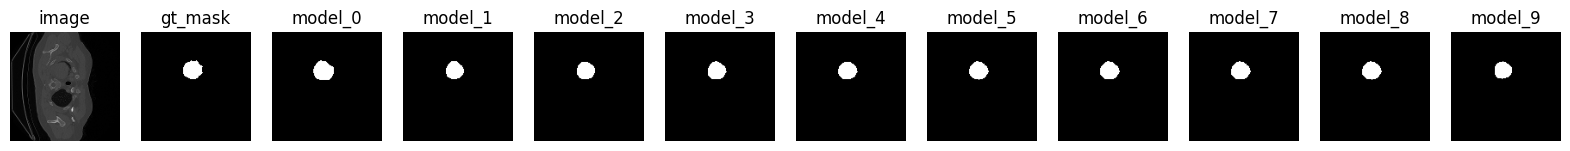

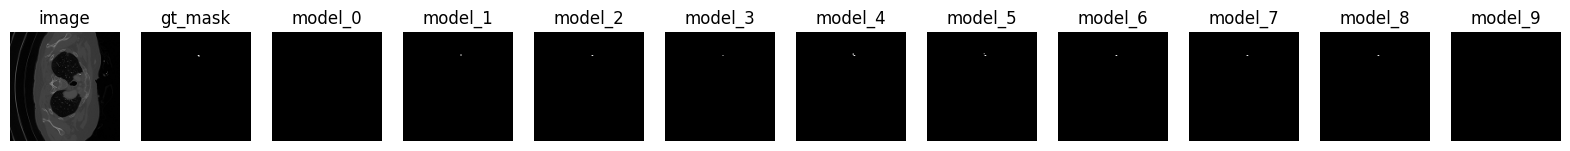

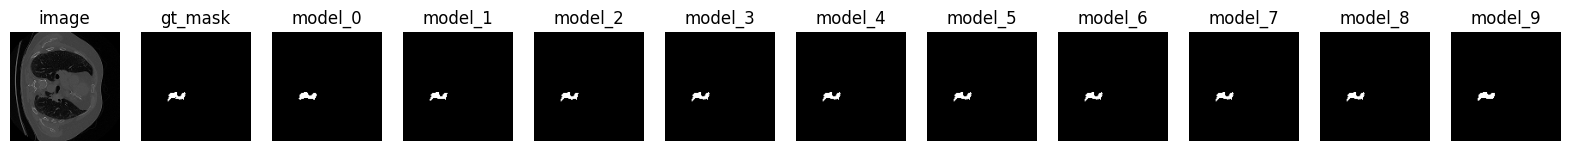

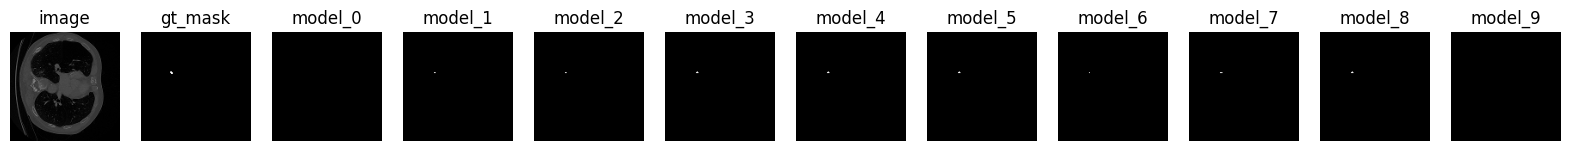

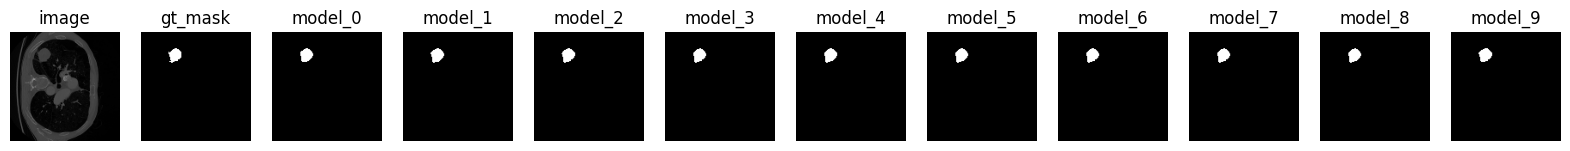

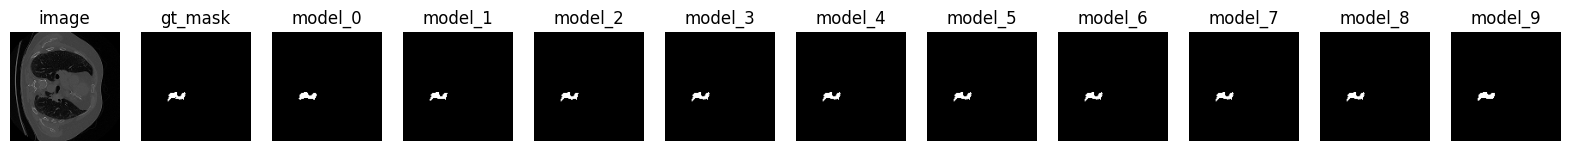

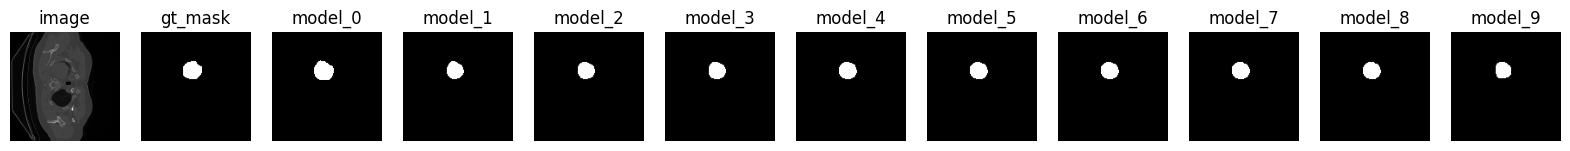

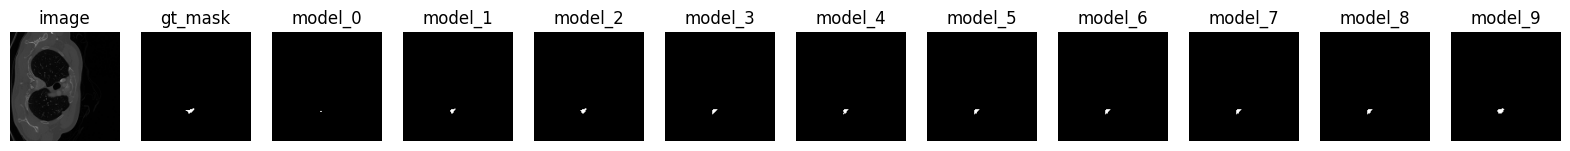

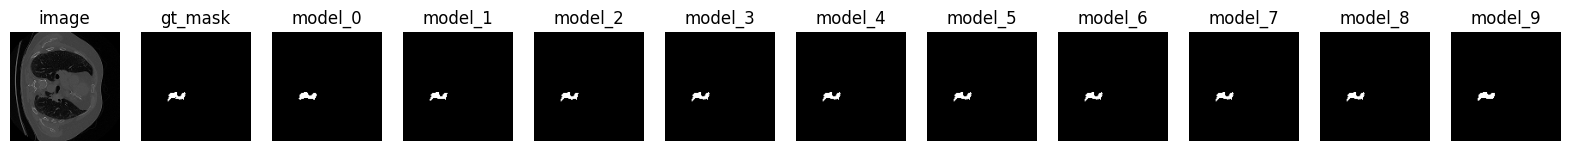

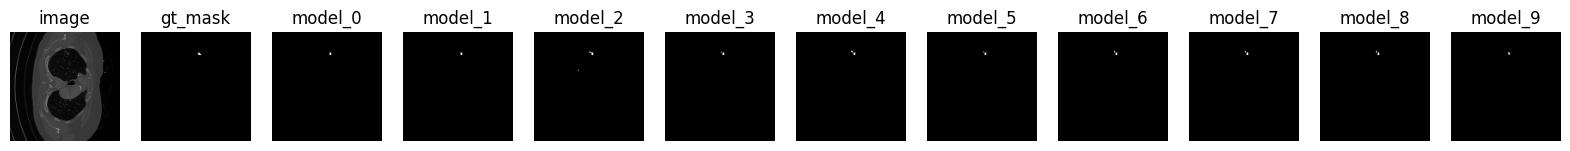

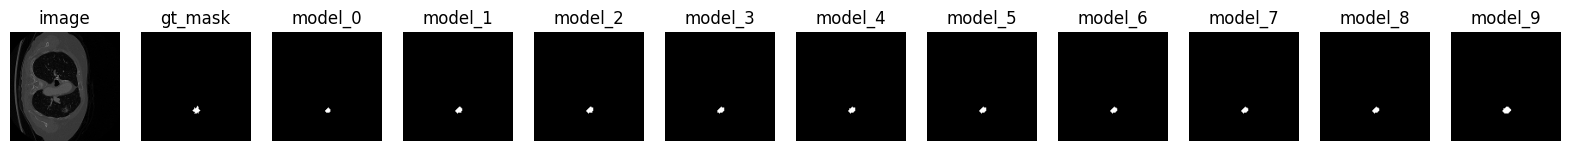

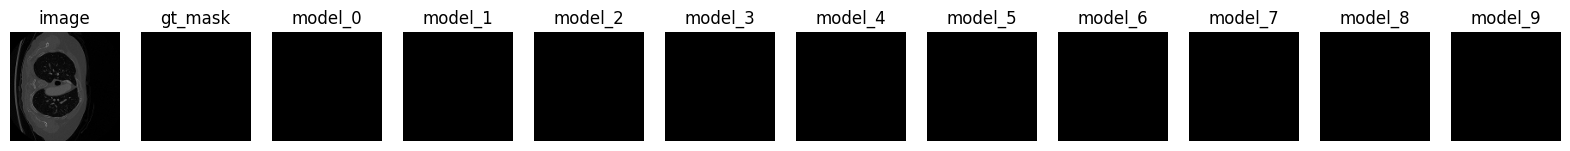

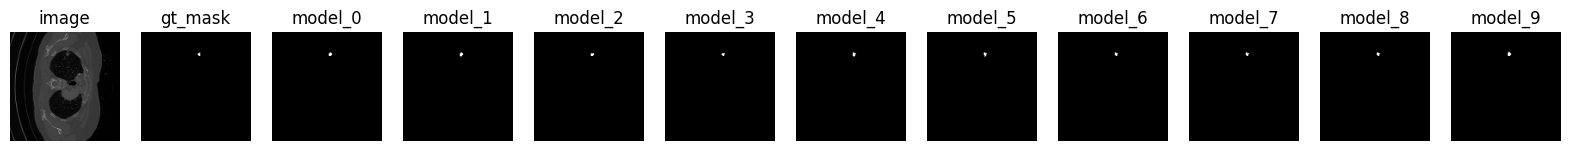

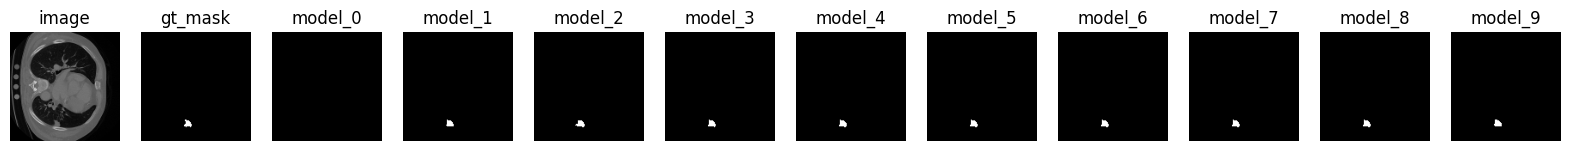

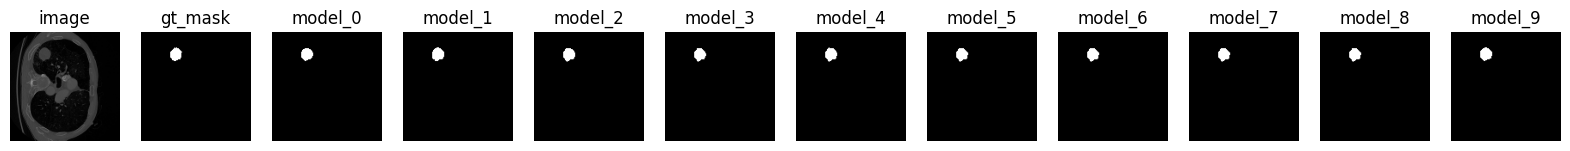

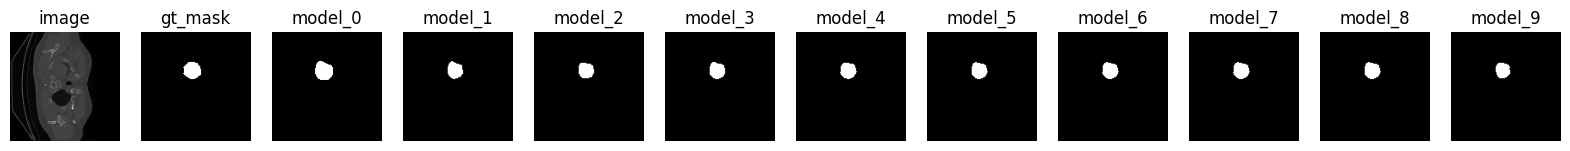

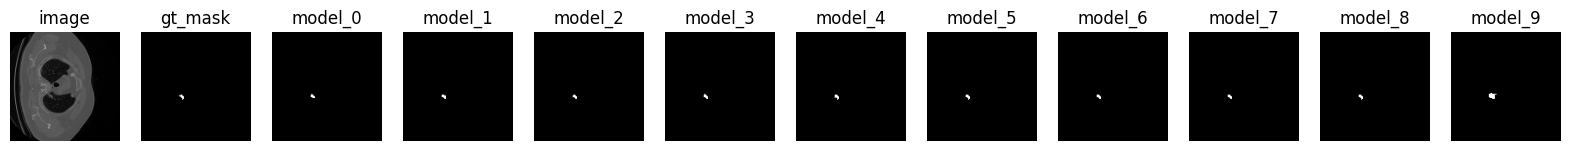

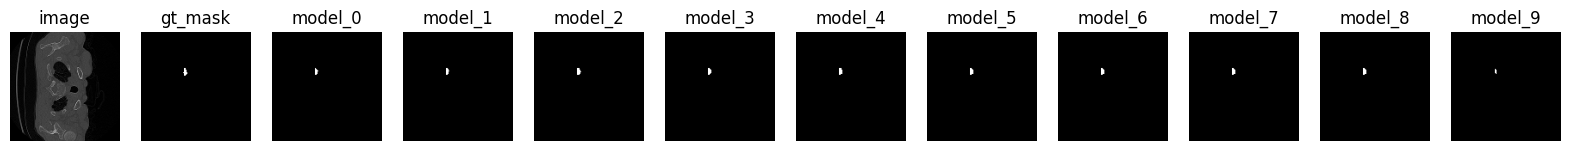

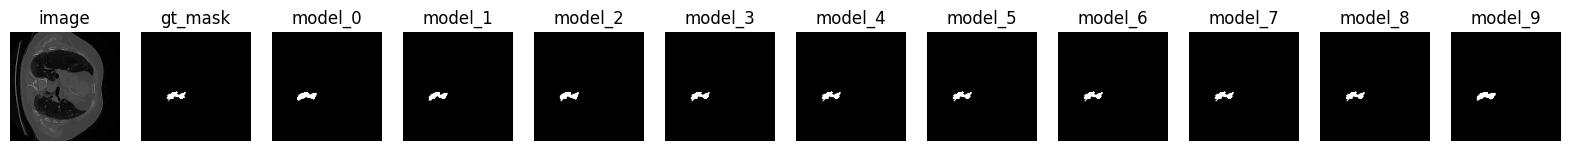

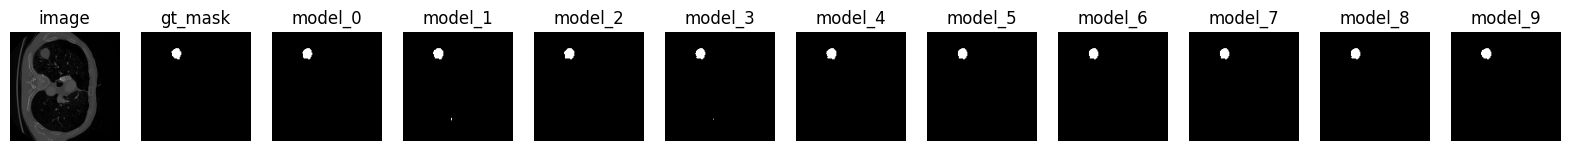

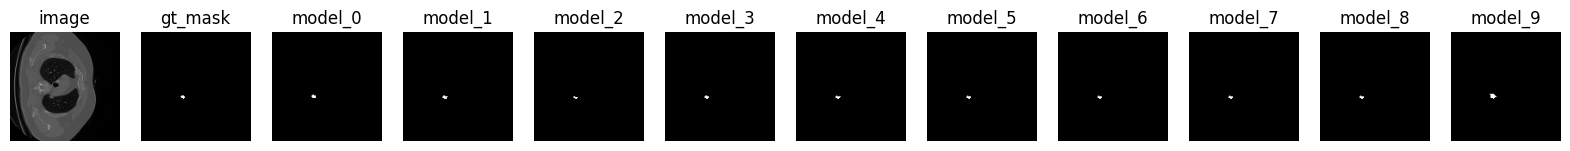

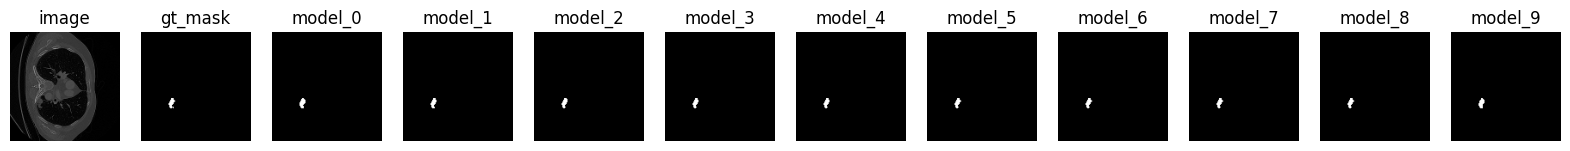

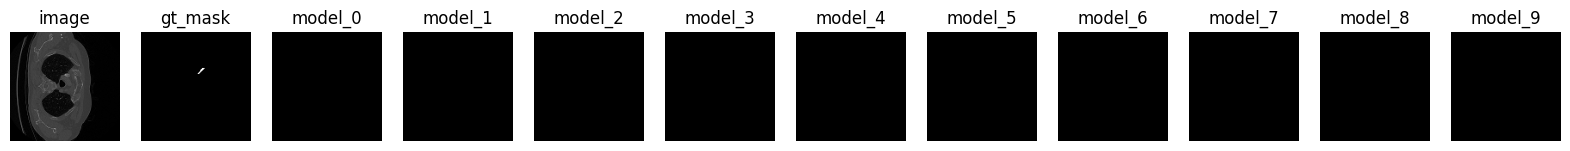

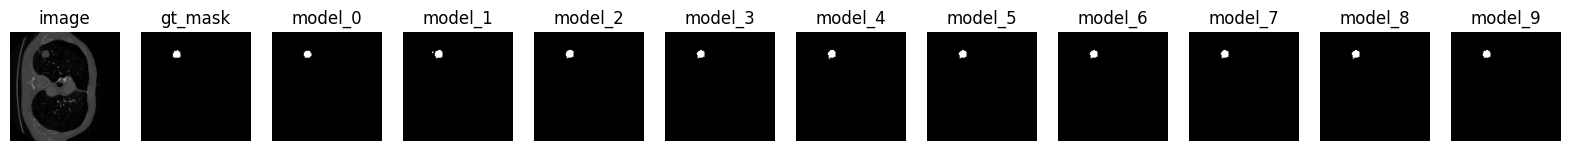

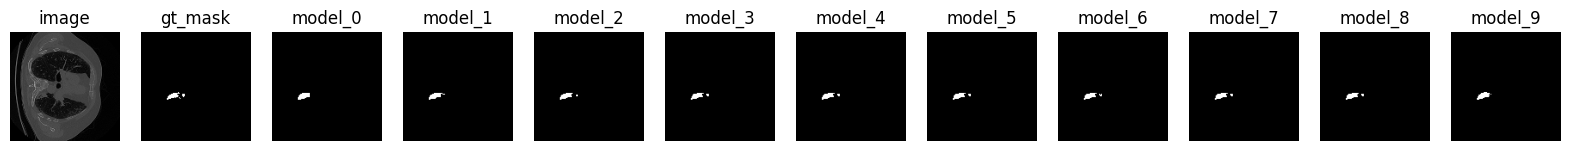

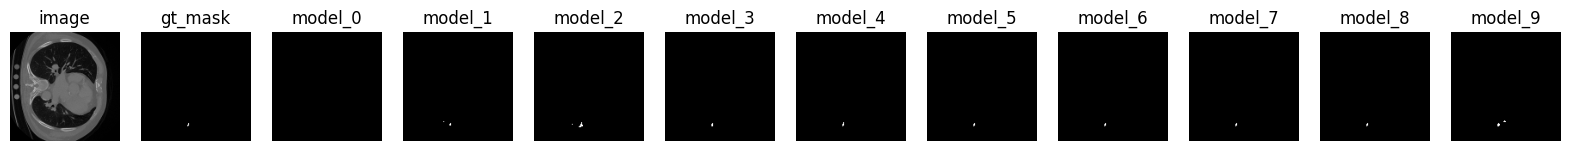

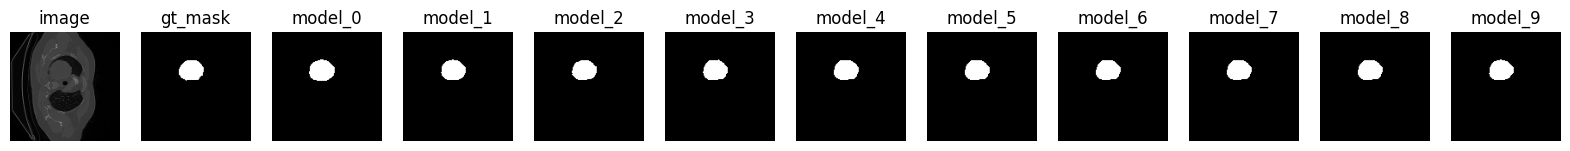

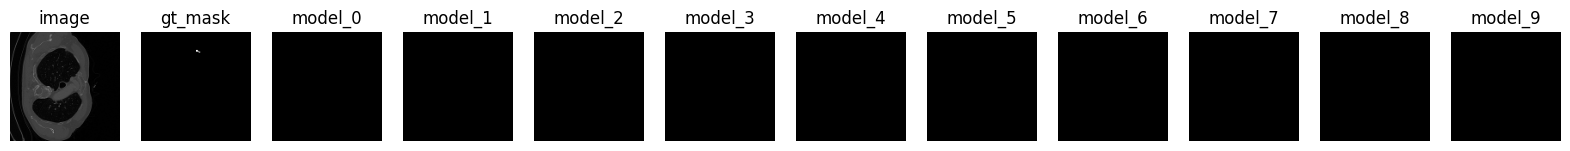

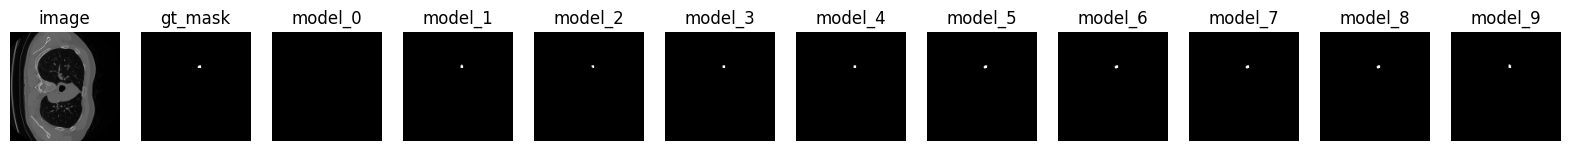

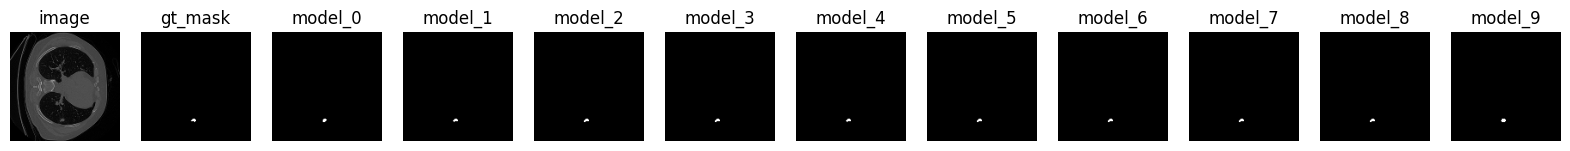

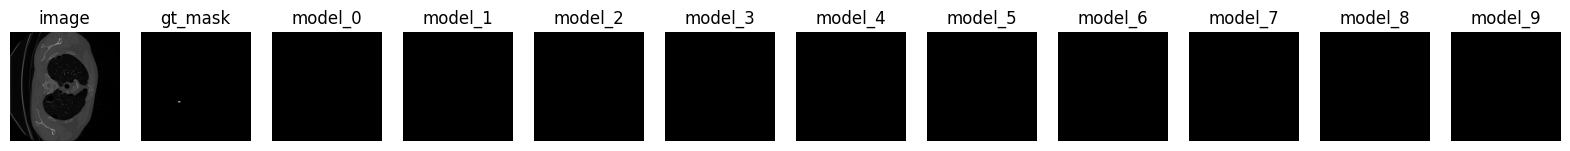

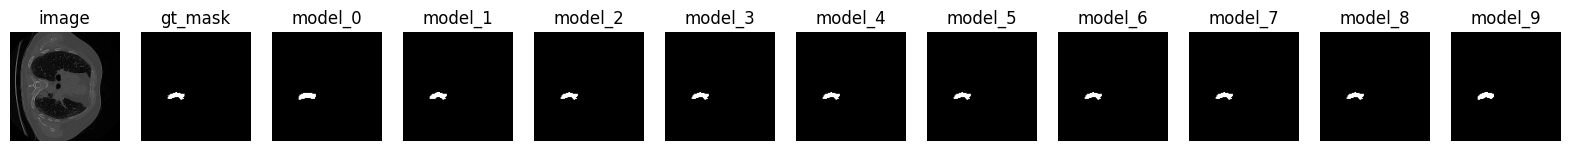

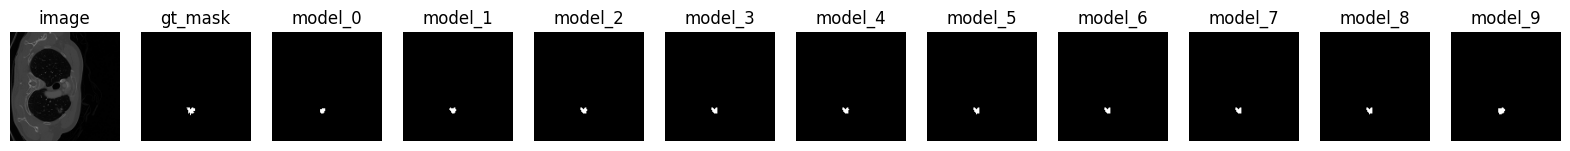

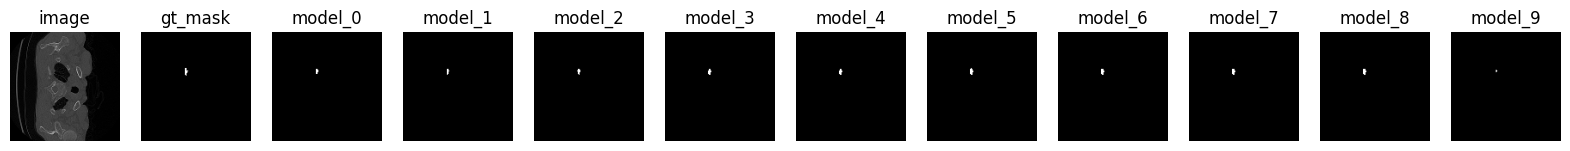

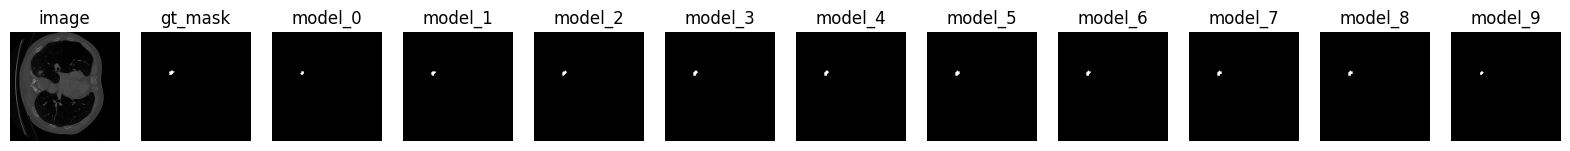

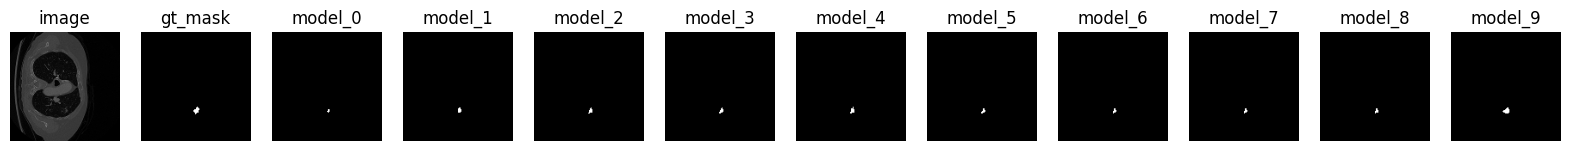

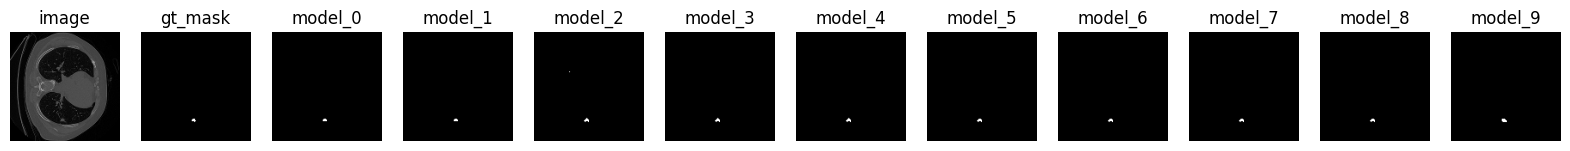

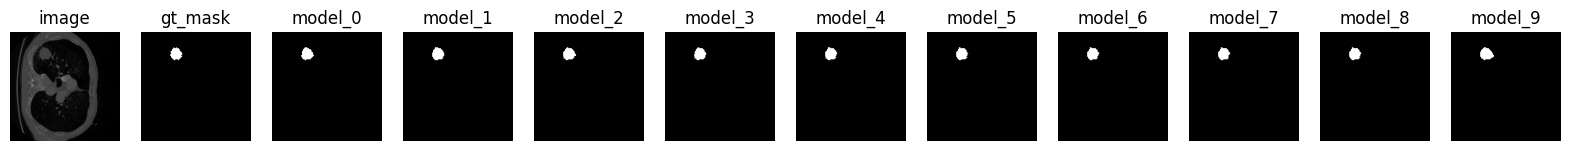

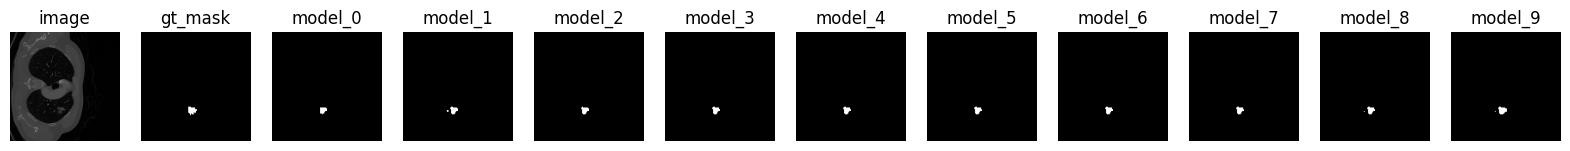

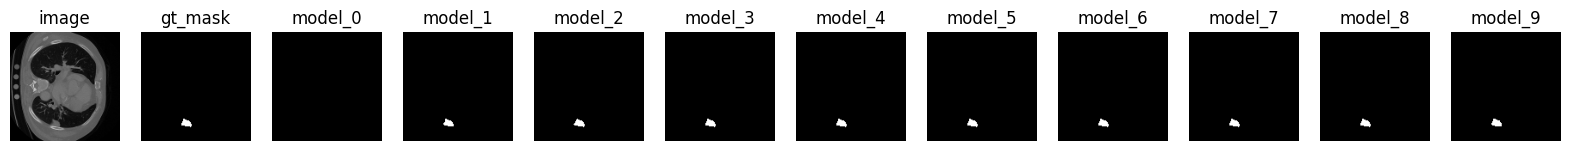

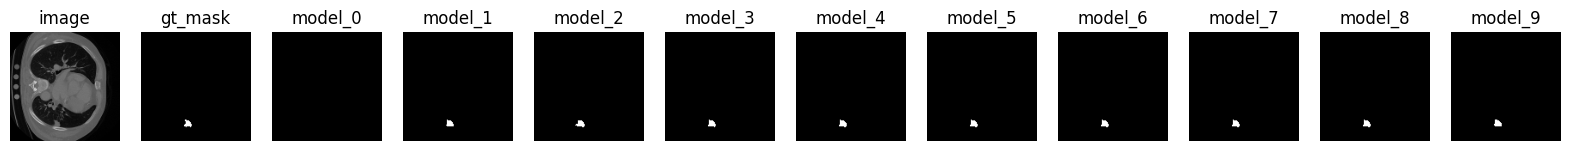

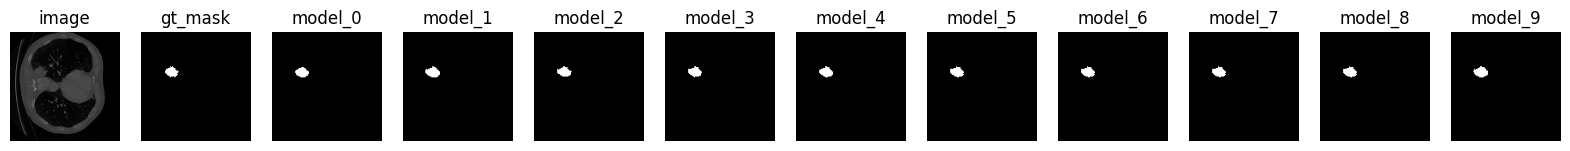

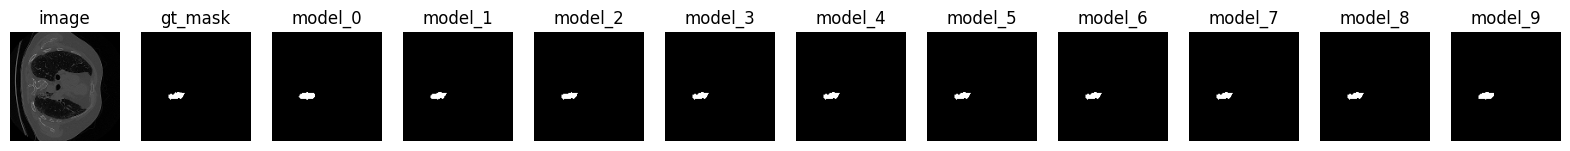

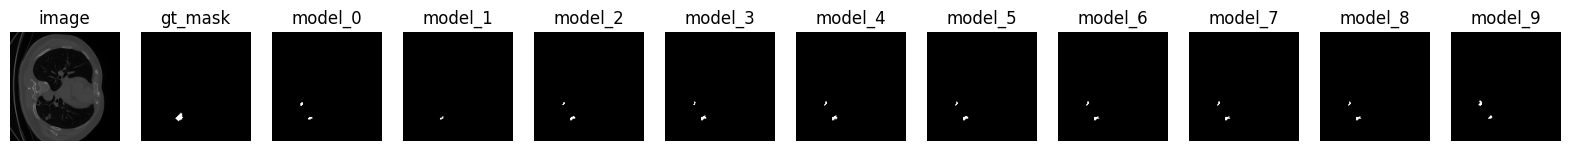

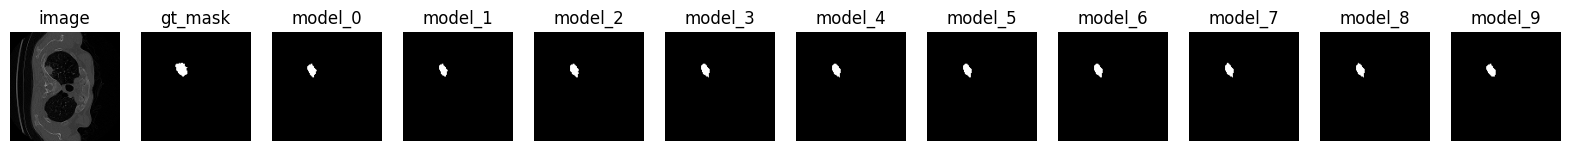

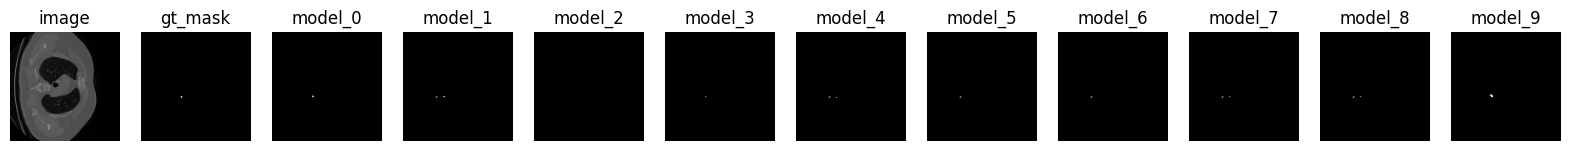

In [17]:
titles = ["image", "gt_mask"] + [f"model_{i}" for i in range(10)]
for i in range(50):
    images_to_plot = []
    images_to_plot.append(images[i])
    images_to_plot.append(gt_masks[i])
    images_to_plot = images_to_plot + voters_dbscan_masks[i]
    sv.plot_images_grid(
        images=images_to_plot,
        grid_size=(1, len(images_to_plot)),
        titles=titles,
        size=(20,20)
        
    )

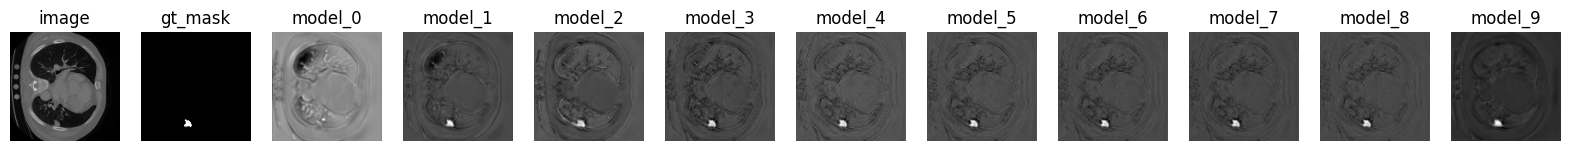

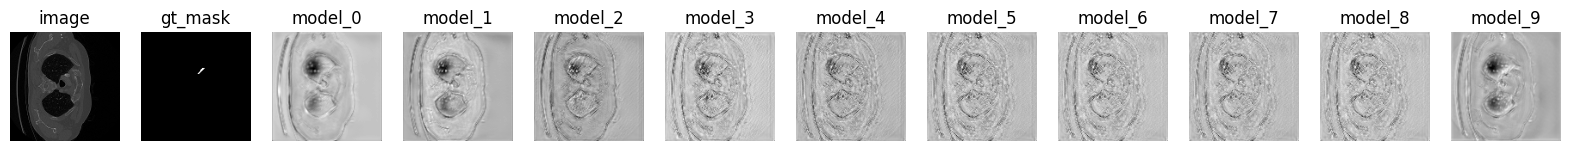

In [18]:
for i in [17,26]:
    images_to_plot = []
    images_to_plot.append(images[i])
    images_to_plot.append(gt_masks[i])
    images_to_plot = images_to_plot + voters_dbscan_logits[i]
    sv.plot_images_grid(
        images=images_to_plot,
        grid_size=(1, len(images_to_plot)),
        titles=titles,
        size=(20,20)
        
    )

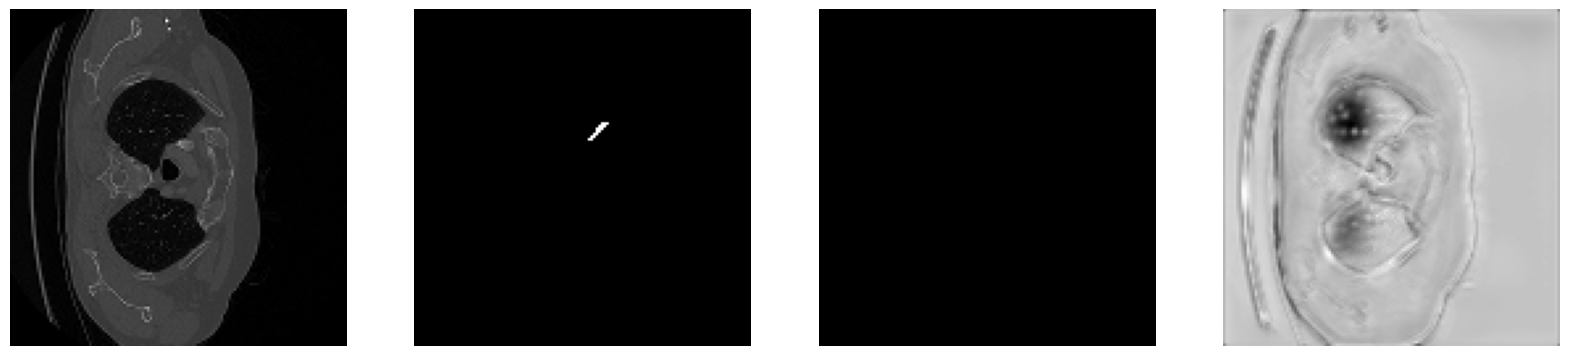

In [57]:
idx = 26
predicted_mask = (voters_dbscan_logits[idx][0].sigmoid()> 0.1).float()
images_to_plot = []
images_to_plot.append(images[idx])
images_to_plot.append(gt_masks[idx])
images_to_plot.append(predicted_mask)
images_to_plot.append(voters_dbscan_logits[idx][0])
sv.plot_images_grid(
    images=images_to_plot,
    grid_size=(1, len(images_to_plot)),
    # titles=titles,
    size=(20,20)
    
)

In [52]:
import torch

In [53]:
dropout = torch.nn.Dropout(p=0.2)

In [58]:
predictions = []
for i in range(10):
    predictions.append(dropout(voters_dbscan_logits[idx][0]).numpy())
    
predictions = np.array(predictions)
mean_prediction = np.mean(predictions, axis=0)

uncertainty = np.var(predictions, axis=0)



In [59]:
predicted_mask = (torch.tensor(mean_prediction).sigmoid()> 0.1).float()

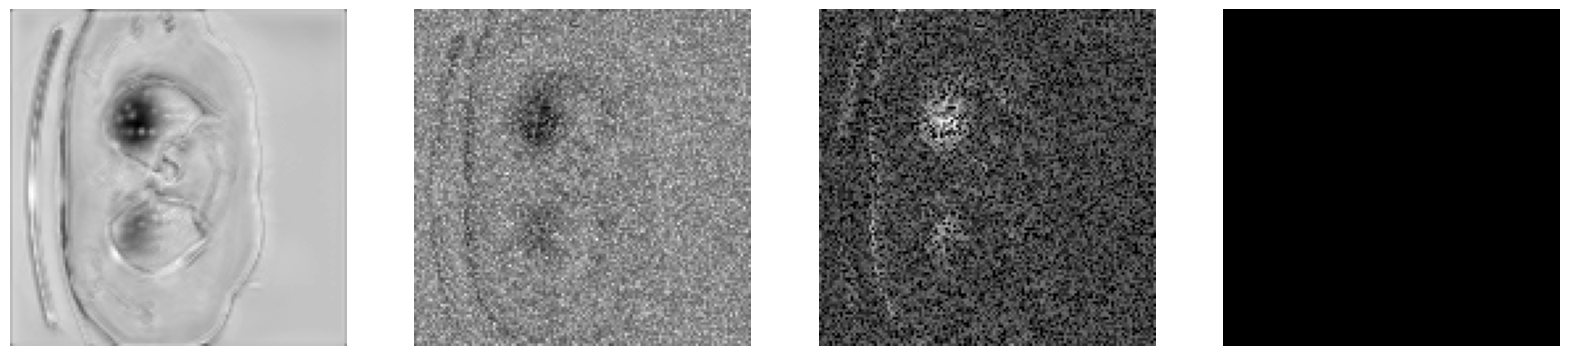

In [60]:
sv.plot_images_grid(
    images=[voters_dbscan_logits[idx][0], mean_prediction, uncertainty, predicted_mask],
    grid_size=(1, 4),
    # titles=titles,
    size=(20,20)
    
)

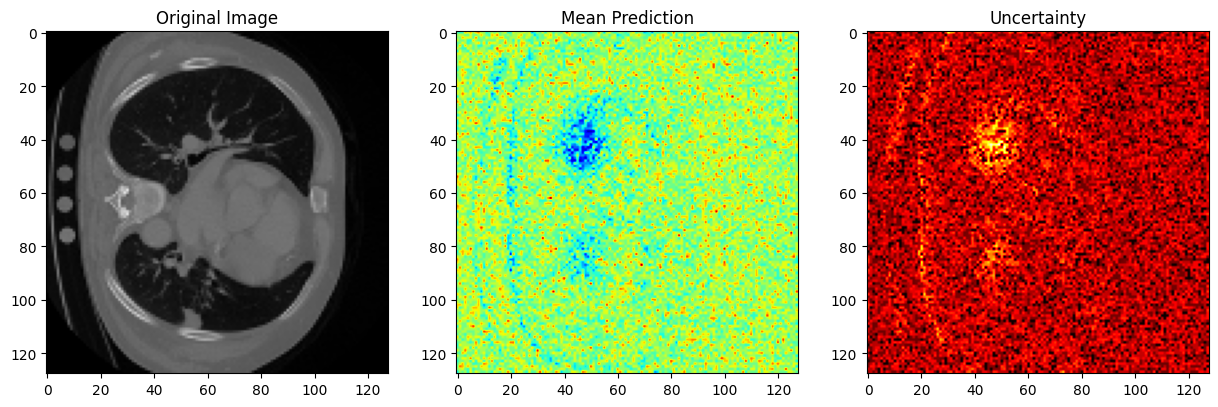

In [61]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(images[17], cmap='gray')
plt.title("Original Image")
plt.subplot(1, 3, 2)
plt.imshow(mean_prediction, cmap='jet')
plt.title("Mean Prediction")
plt.subplot(1, 3, 3)
plt.imshow(uncertainty, cmap='hot')
plt.title("Uncertainty")
plt.show()

In [62]:
masks = np.array(voters_dbscan_logits[idx])
mean_prediction = np.mean(masks, axis=0)
uncertainty = np.var(masks, axis=0)

In [82]:
predicted_mask = (torch.tensor(mean_prediction).sigmoid()> 0.00001).float()

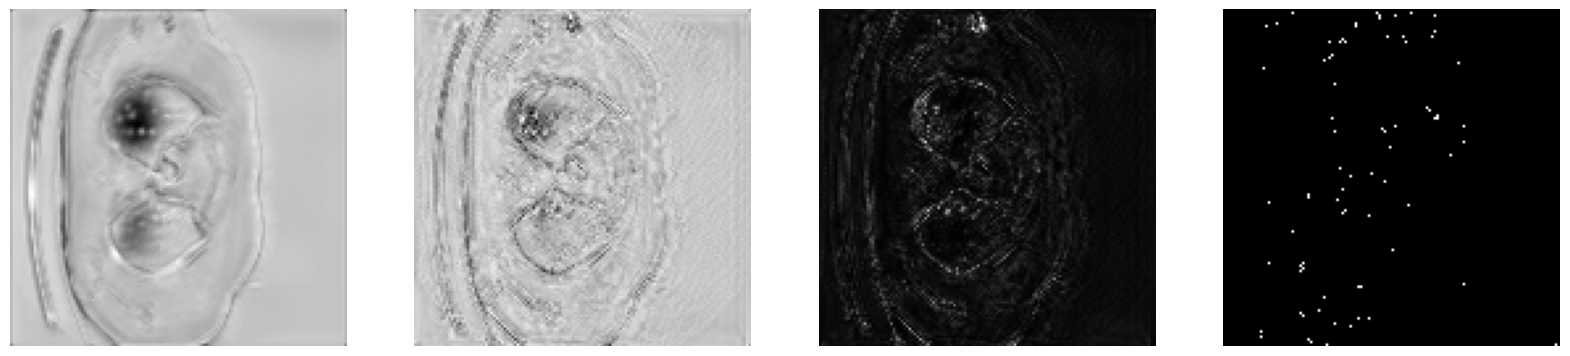

In [83]:
sv.plot_images_grid(
    images=[voters_dbscan_logits[idx][0], mean_prediction, uncertainty, predicted_mask],
    grid_size=(1, 4),
    # titles=titles,
    size=(20,20)
)

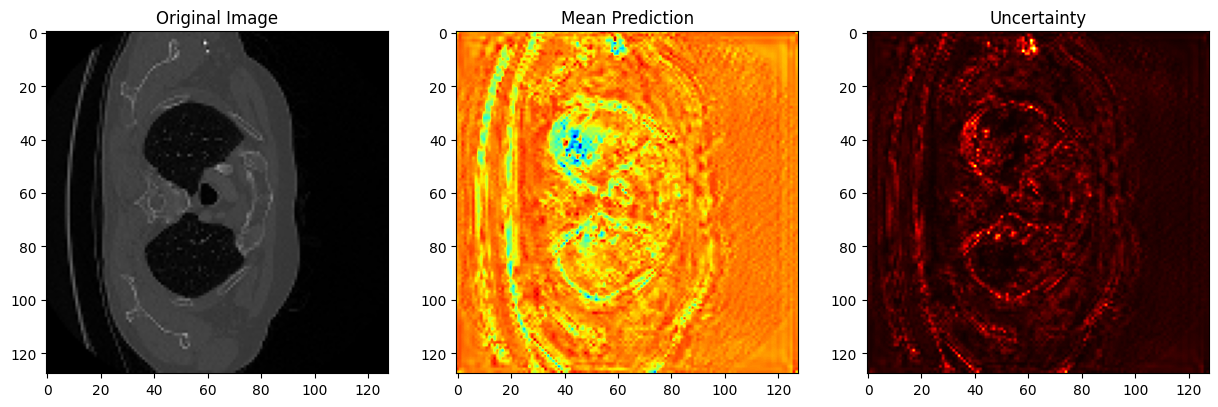

In [65]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(images[idx], cmap='gray')
plt.title("Original Image")
plt.subplot(1, 3, 2)
plt.imshow(mean_prediction, cmap='jet')
plt.title("Mean Prediction")
plt.subplot(1, 3, 3)
plt.imshow(uncertainty, cmap='hot')
plt.title("Uncertainty")
plt.show()